# Imports

In [26]:
!pip install statsmodels
!pip install openpyxl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import seaborn as sns
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text
from matplotlib.legend import Legend
from scipy.stats import ranksums, ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower
import statsmodels.stats.multicomp as mc

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import os
import json


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 5.3 MB/s eta 0:00:004.7 MB/s eta 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


In [27]:
with open('data/paths.json','r') as f:
    paths = json.load(f)

data_path = paths["data_path"]

In [28]:
batch_corrected = True
nan_remove = True
scaler_term = 'minmax'
scaler = MinMaxScaler() if scaler_term=='minmax' else StandardScaler()
data_col_idx = 19 if batch_corrected else 16

test_enc_name = '_BatchCor'+str(batch_corrected)+'_NanRem'+str(nan_remove)+'_'+str(scaler_term)

print(test_enc_name)

_BatchCorTrue_NanRemTrue_minmax


In [29]:
# with open(os.path.join('results','significant_lipids_pls2_treatment'+test_enc_name+'.txt'),'r') as f:
    # lipid_names = f.read().splitlines()
# print(lipid_names)
# print(len(lipid_names))

In [30]:
# len(lipid_names)

In [31]:
sns.set(style = 'whitegrid')

# Load data

In [35]:
data_tmp = pd.read_excel(os.path.join(data_path,'raw_data.xlsx'))
data_tmp.head()
lipid_names = np.unique(data_tmp['Individual Lipid Species'])

In [36]:
metadata = data_tmp.iloc[:,:11]
if batch_corrected:
    data = pd.concat([metadata, data_tmp.iloc[:,19]],axis=1)
else:
    data = pd.concat([metadata, data_tmp.iloc[:,16]],axis=1)

data_stats = data.reset_index().fillna(1e-3*np.min(np.abs(data.iloc[:,-1])))
data_stats.head()

,index,Sample Number,Sample Submission Date,Sample Name,Sex,Tissue weight (mg),Treatment,Tissue Type,PND,Litter,Individual Lipid Species,Lipid Class,BATCH CORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight))
0,0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(14:0)+H,SM,0.000842
1,1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(16:0)+H,SM,0.006390
2,2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:0)+H,SM,0.036989
3,3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:1)+H,SM,0.046320
4,4,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(20:0)+H,SM,0.001167


In [37]:
data = data_stats.loc[data_stats['Individual Lipid Species'].isin(lipid_names)].copy(deep=True)
data.columns = ['Index','SampleNumber', 'SampleSubmissionDate', 'SampleName', 'Sex', 'TissueWeight', 'Treatment', 'TissueType', 'PND', 'Litter', 'IndividualLipidSpecies', 'LipidClass', 'PeakArea']
data.head()

,Index,SampleNumber,SampleSubmissionDate,SampleName,Sex,TissueWeight,Treatment,TissueType,PND,Litter,IndividualLipidSpecies,LipidClass,PeakArea
0,0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(14:0)+H,SM,0.000842
1,1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(16:0)+H,SM,0.006390
2,2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:0)+H,SM,0.036989
3,3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:1)+H,SM,0.046320
4,4,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(20:0)+H,SM,0.001167


In [38]:
data['Sex'].value_counts()
data['SampleSubmissionDate'].value_counts()

SampleSubmissionDate
09/2021    54768
11/2022    27384
Name: count, dtype: int64

In [39]:
data['log_area'] = np.log10(data.iloc[:,-1])
data['log_scaled_area'] = scaler.fit_transform(data[['log_area']])
data.head()

,Index,SampleNumber,SampleSubmissionDate,SampleName,Sex,TissueWeight,Treatment,TissueType,PND,Litter,IndividualLipidSpecies,LipidClass,PeakArea,log_area,log_scaled_area
0,0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(14:0)+H,SM,0.000842,-3.074916,0.647776
1,1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(16:0)+H,SM,0.006390,-2.194512,0.719944
2,2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:0)+H,SM,0.036989,-1.431924,0.782454
3,3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:1)+H,SM,0.046320,-1.334233,0.790462
4,4,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(20:0)+H,SM,0.001167,-2.932747,0.659430


# Manipulate data

Add a column to identify the date

In [40]:
def classify_date(input_date):
    if input_date == '09/2021':
        return 1
    else:
        return 2

data['dateId'] = data['SampleSubmissionDate'].apply(lambda x: classify_date(x))

In [41]:
df_sub = data[(data['TissueType'] == 'cortex') & (data['PND'] == 30)].copy()
df_sub['class'] = [0 if x == 'control' else 1 for x in df_sub['Treatment']]

df_pivot = df_sub.pivot_table(index='IndividualLipidSpecies', columns='SampleNumber',values='log_scaled_area',dropna=True).T


class_values = df_sub.groupby('SampleNumber').mean()['class']

print(df_pivot.columns)


TypeError: Could not convert 09/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/202109/2021 to numeric

# Figures

In [42]:
data.shape

(82152, 16)

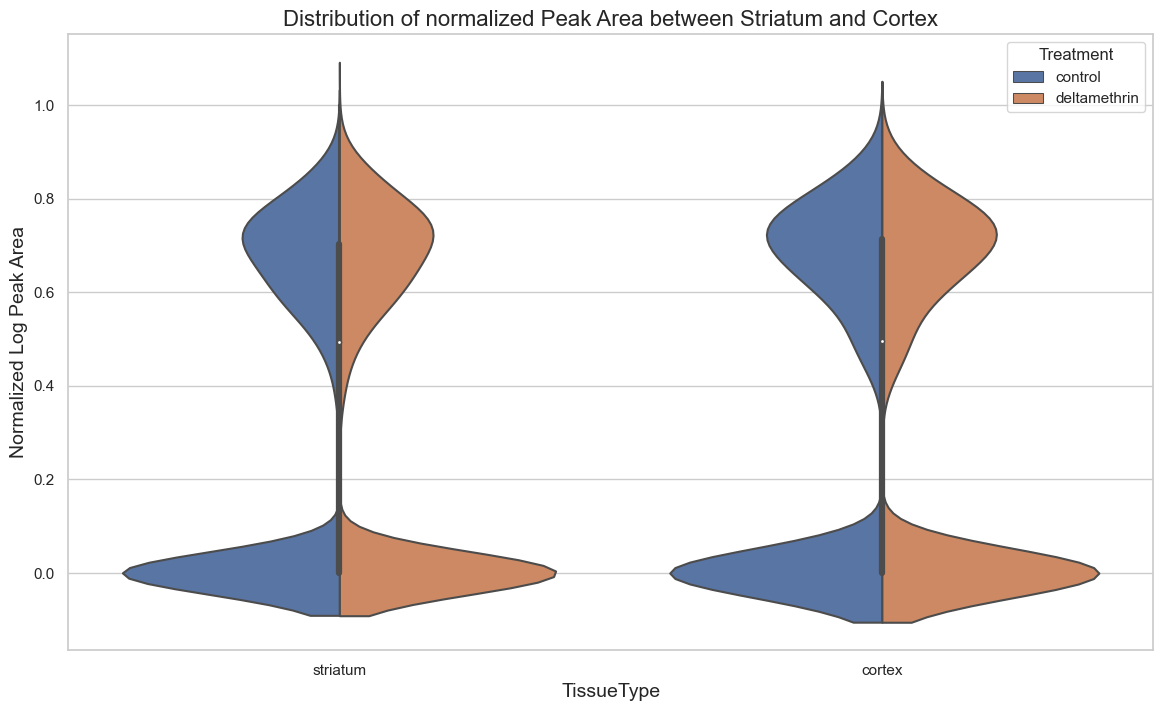

In [43]:
fig = plt.figure(figsize=(14,8), dpi=100)
ax = sns.violinplot(data=data, x='TissueType', hue='Treatment', y='log_scaled_area',split=True, inner='box')

ax.set_title('Distribution of normalized Peak Area between Striatum and Cortex', fontsize=16)
ax.set_xlabel('TissueType', fontsize=14)
ax.set_ylabel('Normalized Log Peak Area', fontsize=14)

fig.savefig(os.path.join(data_path,"violinplot-tissue-no-date.png"), format='png', facecolor='w')

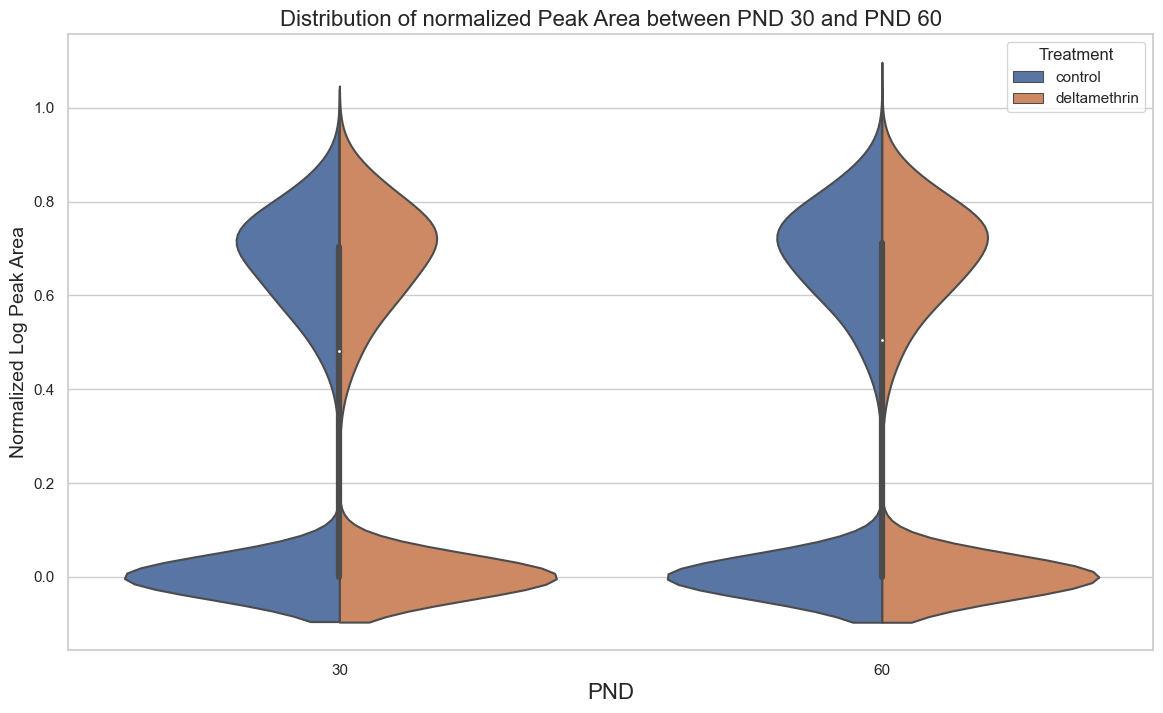

In [44]:
fig = plt.figure(figsize=(14,8), dpi=100)
ax = sns.violinplot(data=data, x='PND', hue='Treatment', y='log_scaled_area',split=True, inner='box')
ax.set_title('Distribution of normalized Peak Area between PND 30 and PND 60', fontsize=16)
ax.set_xlabel('PND', fontsize=16)
ax.set_ylabel('Normalized Log Peak Area', fontsize=14)
                    
fig.savefig(os.path.join(data_path,"violinplot-pnd-no-date.png"), format='png', facecolor='w')

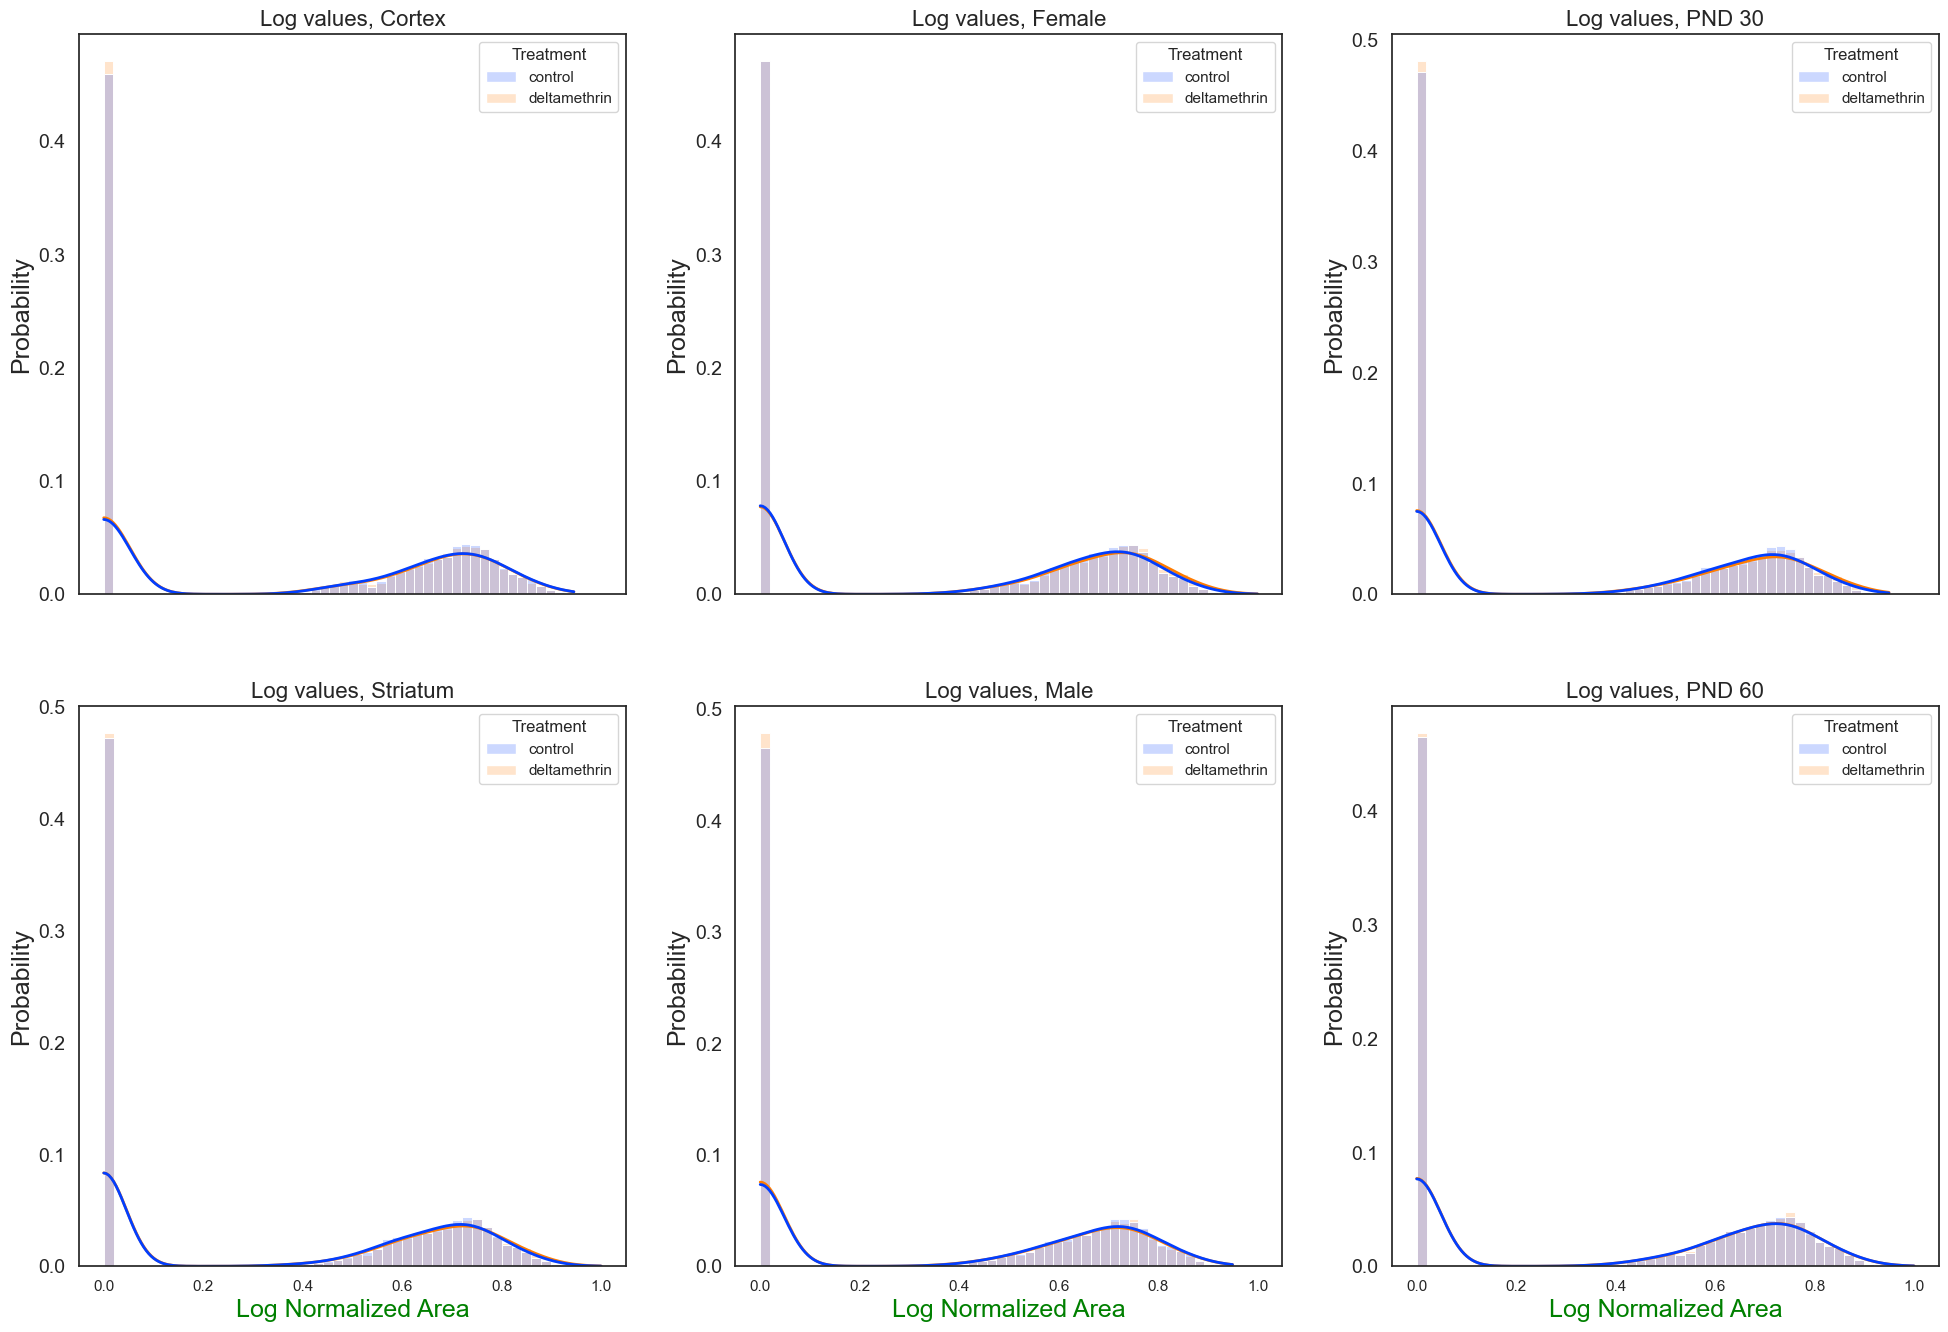

In [45]:
sns.set_style('white')

fig, ax = plt.subplots(2, 3, sharex=True, figsize=(24,16), )

opt = {'bins': 50, 'alpha': 0.2, 'palette': 'bright',
        'stat': 'probability', 'kde': True,
        'line_kws': {'lw': 2}, 'common_norm': False}

sns.histplot(data=data[data['TissueType'] == 'cortex'], x='log_scaled_area', hue='Treatment', ax=ax[0,0], legend=True, **opt)
ax[0,0].set_title('Log values, Cortex', fontsize=16)
ax[0,0].set_ylabel('Probability', fontsize=18)
ax[0,0].tick_params(axis='y', labelsize=14)
sns.histplot(data=data[data['TissueType'] == 'striatum'], x='log_scaled_area', hue='Treatment', ax=ax[1,0], legend=True, **opt)
ax[1,0].set_title('Log values, Striatum', fontsize=16)
ax[1,0].set_xlabel('Log Normalized Area', fontsize=18, color='green')
ax[1,0].set_ylabel('Probability', fontsize=18)
ax[1,0].tick_params(axis='y', labelsize=14)

sns.histplot(data=data[data['Sex'] == 'F'], x='log_scaled_area', hue='Treatment', ax=ax[0,1], legend=True, **opt)
ax[0,1].set_title('Log values, Female', fontsize=16)
ax[0,1].set_ylabel('Probability', fontsize=18)
ax[0,1].tick_params(axis='y', labelsize=14)
sns.histplot(data=data[data['Sex'] == 'M'], x='log_scaled_area', hue='Treatment', ax=ax[1,1], legend=True, **opt)
ax[1,1].set_title('Log values, Male', fontsize=16)
ax[1,1].set_xlabel('Log Normalized Area', fontsize=18, color='green')
ax[1,1].set_ylabel('Probability', fontsize=18)
ax[1,1].tick_params(axis='y', labelsize=14)

sns.histplot(data=data[data['PND'] == 30], x='log_scaled_area', hue='Treatment', ax=ax[0,2], legend=True, **opt)
ax[0,2].set_title('Log values, PND 30', fontsize=16)
ax[0,2].set_ylabel('Probability', fontsize=18)
ax[0,2].tick_params(axis='y', labelsize=14)
sns.histplot(data=data[data['PND'] == 60], x='log_scaled_area', hue='Treatment', ax=ax[1,2], legend=True, **opt)
ax[1,2].set_title('Log values, PND 60', fontsize=16)
ax[1,2].set_xlabel('Log Normalized Area', fontsize=18, color='green')
ax[1,2].set_ylabel('Probability', fontsize=18)
ax[1,2].tick_params(axis='y', labelsize=14)

fig.savefig(os.path.join(data_path,"distribution-3cases-no-date.png"), format='png', facecolor='w', dpi=300)

plt.show()

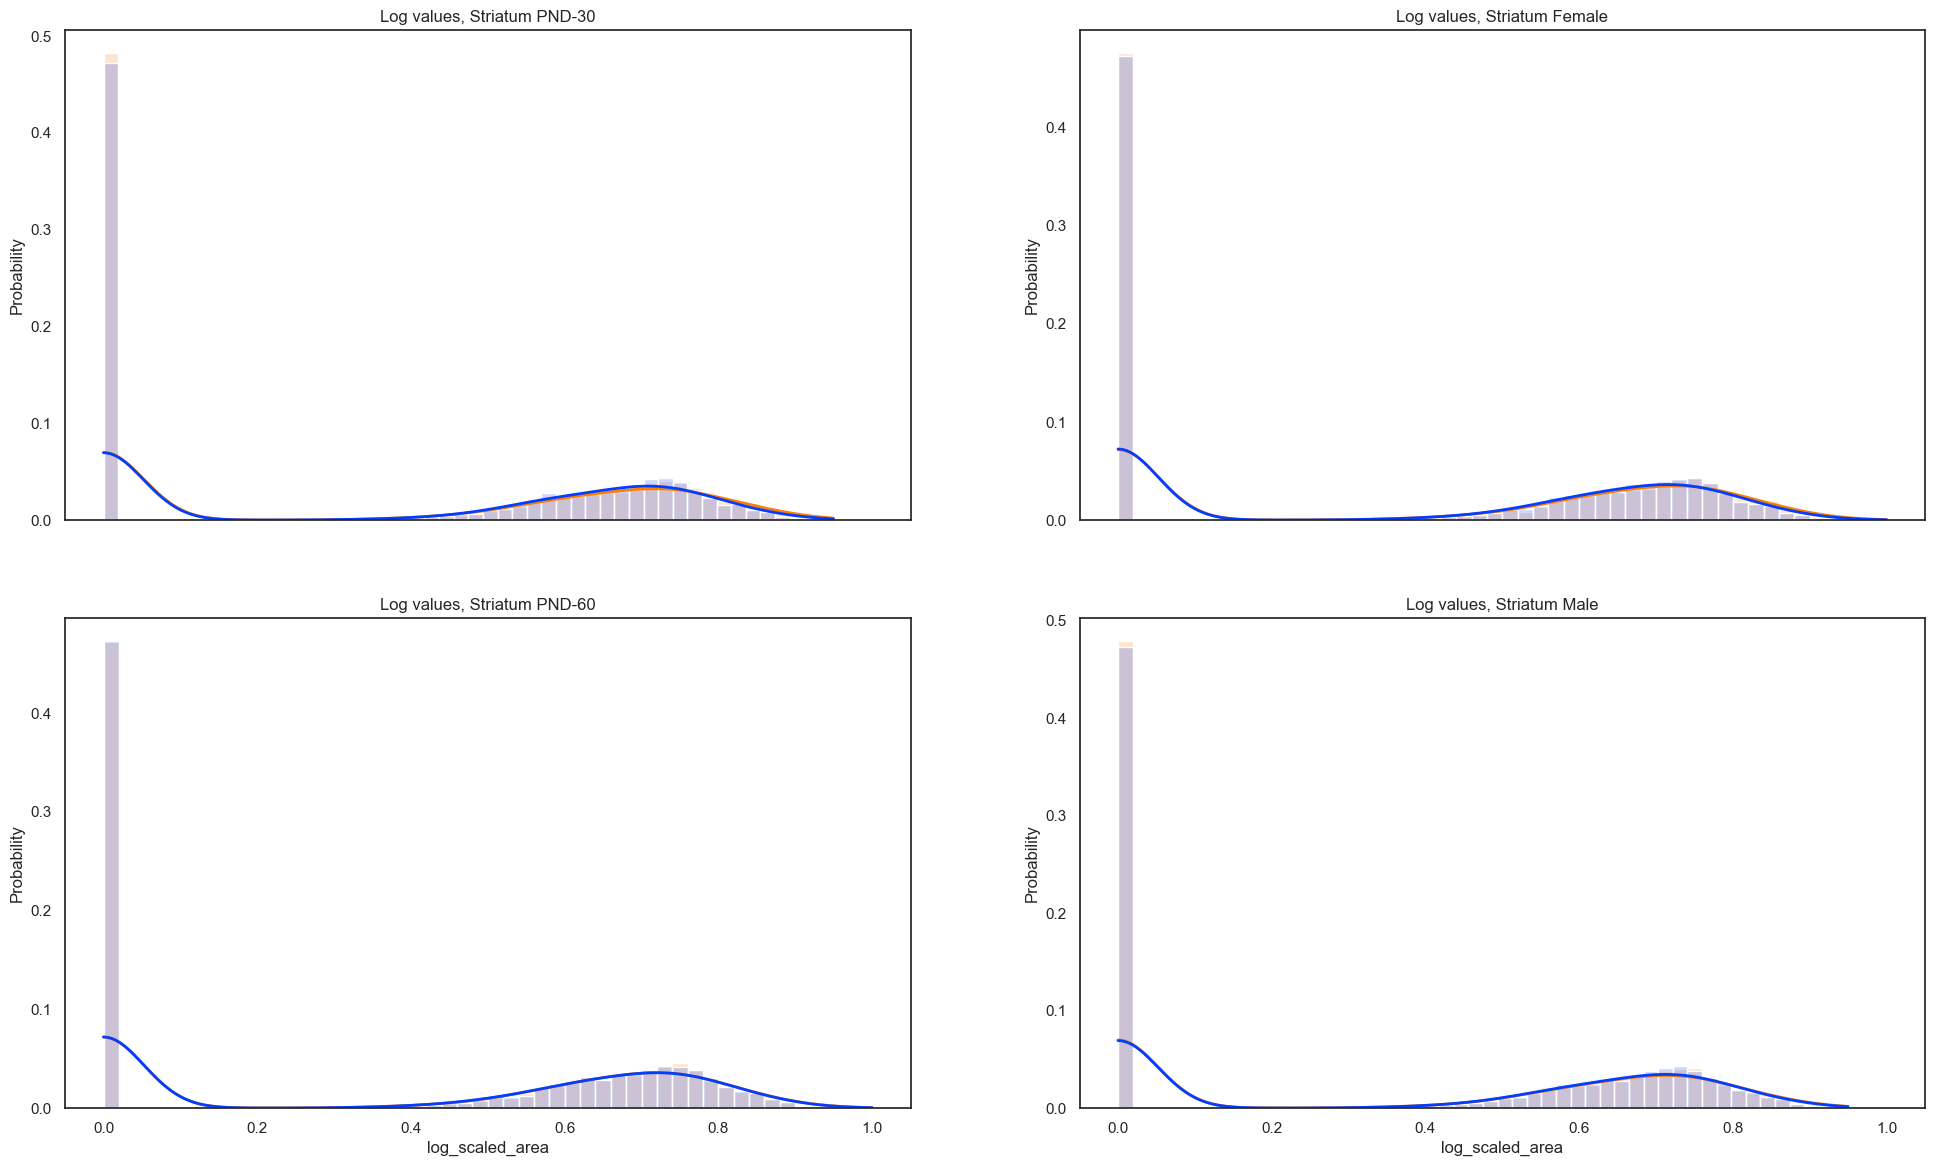

In [46]:
sns.set_style('white')

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(24,14))

opt = {'bins': 50, 'alpha': 0.2, 'palette': 'bright',
        'stat': 'probability', 'kde': True,
        'line_kws': {'lw': 2}, 'common_norm': False}

sns.histplot(data=data[(data['TissueType'] == 'striatum') & (data['PND'] == 30)], x='log_scaled_area', hue='Treatment', ax=ax[0,0], legend=False, **opt)
ax[0,0].set_title('Log values, Striatum PND-30')
sns.histplot(data=data[(data['TissueType'] == 'striatum') & (data['PND'] == 60)], x='log_scaled_area', hue='Treatment', ax=ax[1,0], legend=False, **opt)
ax[1,0].set_title('Log values, Striatum PND-60')

sns.histplot(data=data[(data['TissueType'] == 'striatum') & (data['Sex'] == 'F')], x='log_scaled_area', hue='Treatment', ax=ax[0,1], legend=False, **opt)
ax[0,1].set_title('Log values, Striatum Female')
sns.histplot(data=data[(data['TissueType'] == 'striatum') & (data['Sex'] == 'M')], x='log_scaled_area', hue='Treatment', ax=ax[1,1], legend=False, **opt)
ax[1,1].set_title('Log values, Striatum Male')

fig.savefig(os.path.join(data_path,"distribution-Striatum-2cases.svg"), format='svg', facecolor='w')

plt.show()

# Statistics

## Wilcoxon test applied on the data with no normalization

#### Data divided by tissue

In [47]:
tissue = ['striatum','cortex']
sex = ['F', 'M']
pnd = [30,60]
var_name = 'log_scaled_area'


for t in tissue:
    a = data[(data['Treatment'] == 'control') & (data['TissueType']==t)][var_name]
    b = data[(data['Treatment'] == 'deltamethrin') & (data['TissueType']==t)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Tissue: {t}. P-value: {ranksums(a,b).pvalue:.2e}')

Tissue: striatum. P-value: 4.36e-01
Tissue: cortex. P-value: 1.47e-01


#### Data divided by gender

In [48]:
for g in sex:
    a = data[(data['Treatment'] == 'control') & (data['Sex']==g)][var_name]
    b = data[(data['Treatment'] == 'deltamethrin') & (data['Sex']==g)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Gender: {g}. P-value: {ranksums(a,b).pvalue:.2e}')

Gender: F. P-value: 1.76e-02
Gender: M. P-value: 8.29e-03


#### Data divided by PND

In [49]:
for p in pnd:
    a = data[(data['Treatment'] == 'control') & (data['PND']==p)][var_name]
    b = data[(data['Treatment'] == 'deltamethrin') & (data['PND']==p)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'PND: {p}. P-value: {ranksums(a,b).pvalue:.2e}')

PND: 30. P-value: 9.55e-01
PND: 60. P-value: 7.02e-01


## T-test applied on the data with log normalization

#### Data divided by tissue

In [50]:
tissue = ['striatum','cortex']
sex = ['F', 'M']
pnd = [30,60]
var_name = 'log_scaled_area'

for t in tissue:
    a = data[(data['Treatment'] == 'control') & (data['TissueType']==t)][var_name]
    b = data[(data['Treatment'] == 'deltamethrin') & (data['TissueType']==t)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Tissue: {t}. P-value: {ttest_ind(a,b).pvalue:.2e}')

Tissue: striatum. P-value: 9.11e-01
Tissue: cortex. P-value: 7.05e-02


#### Data divided by gender

In [51]:
for g in sex:
    a = data[(data['Treatment'] == 'control') & (data['Sex']==g)][var_name]
    b = data[(data['Treatment'] == 'deltamethrin') & (data['Sex']==g)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Gender: {g}. P-value: {ttest_ind(a,b).pvalue:.2e}')

Gender: F. P-value: 2.28e-01
Gender: M. P-value: 4.61e-03


#### Data divided by PND

In [52]:
for p in pnd:
    a = data[(data['Treatment'] == 'control') & (data['PND']==p)][var_name]
    b = data[(data['Treatment'] == 'deltamethrin') & (data['PND']==p)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'PND: {p}. P-value: {ranksums(a,b).pvalue:.2e}')

PND: 30. P-value: 9.55e-01
PND: 60. P-value: 7.02e-01


## Three-way ANOVA on log normalized data

#### Quelli singoli sono mediati su tutto il resto. Mentre l'effetto del secondo oridne dice che è vero che partono da livelli differenti diversi striato e corteccia, ma l'effetto del trattamento ha effetto anche se loro sono già diversi

In [53]:
model = ols('log_scaled_area ~ C(Sex) + C(Treatment) + C(TissueType) + C(dateId) + C(PND) + C(PND):C(Treatment) + C(Sex):C(Treatment) + C(TissueType):C(Treatment) + C(dateId):C(Treatment)', data=data).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Sex),0.284901,1.0,2.312571,1.283355e-01
C(Treatment),0.160631,1.0,1.303854,2.535138e-01
C(TissueType),0.329333,1.0,2.673227,1.020527e-01
C(dateId),11.125865,1.0,90.309712,2.088792e-21
C(PND),2.097745,1.0,17.027600,3.687666e-05
C(PND):C(Treatment),0.016547,1.0,0.134311,7.140046e-01
C(Sex):C(Treatment),1.002913,1.0,8.140739,4.329246e-03
C(TissueType):C(Treatment),0.084874,1.0,0.688929,4.065313e-01
C(dateId):C(Treatment),0.079014,1.0,0.641361,4.232207e-01
Residual,10119.629312,82142.0,NaN,NaN


In [54]:
model = ols('log_scaled_area ~ C(Sex) + C(PND) + C(Treatment) + C(TissueType) + C(PND):C(Treatment) + C(Sex):C(Treatment) + C(TissueType):C(Treatment)', data=data).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Sex),0.284901,1.0,2.310069,0.128542
C(PND),2.097745,1.0,17.009182,0.000037
C(Treatment),0.160631,1.0,1.302444,0.253771
C(TissueType),1.595482,1.0,12.936673,0.000322
C(PND):C(Treatment),0.016547,1.0,0.134166,0.714152
C(Sex):C(Treatment),1.002913,1.0,8.131933,0.004350
C(TissueType):C(Treatment),0.248691,1.0,2.016468,0.155604
Residual,10130.834191,82144.0,NaN,NaN


### Anova only striatum

In [55]:
data_striatum = data[data['TissueType'] == 'striatum'].copy(deep=True)

In [56]:
model = ols('log_scaled_area ~ C(Sex) + C(Treatment)  + C(Sex):C(Treatment)', data=data_striatum).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Sex),0.388933,1.0,3.169212,0.075044
C(Treatment),0.001546,1.0,0.012600,0.910626
C(Sex):C(Treatment),0.095255,1.0,0.776185,0.378314
Residual,6720.757880,54764.0,NaN,NaN


In [57]:
model = ols('log_scaled_area ~ C(Sex) + C(PND) + C(Treatment)+ C(PND):C(Treatment) + C(Sex):C(Treatment)', data=data_striatum).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Sex),0.388933,1.0,3.169489,0.075031
C(PND),0.804813,1.0,6.558578,0.010441
C(Treatment),0.001546,1.0,0.012601,0.910622
C(PND):C(Treatment),0.028646,1.0,0.233446,0.628982
C(Sex):C(Treatment),0.095255,1.0,0.776253,0.378293
Residual,6719.924421,54762.0,NaN,NaN


# Single lipids statistics

## Define lipids list

In [58]:
lipids_list = data['IndividualLipidSpecies'].unique()
print(lipids_list.shape[0])

1141


## Test lipid

In [59]:
data_lipid = data[data['IndividualLipidSpecies'] == lipids_list[0]]

from scipy.stats import ttest_ind
multcomp = mc.MultiComparison(data_lipid['log_scaled_area'], groups=data_lipid['Treatment'])
res = multcomp.allpairtest(ttest_ind)[1][2][0]
print(res)
res = multcomp.allpairtest(ttest_ind)[0]
print(res)

0.03291756208611551
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
 group1    group2     stat   pval  pval_corr reject
---------------------------------------------------
control deltamethrin 2.1762 0.0329    0.0329   True
---------------------------------------------------


## Analysis control vs treatment

In [60]:
lipids_list.shape

(1141,)

In [61]:
import itertools
factor = 'Sex'
results_all = []
for l in lipids_list:
    data_lipid = data[data['IndividualLipidSpecies'] == l]
    if data_lipid[factor].unique().size > 1: # Some lipids are not found in both classes
        for c in itertools.combinations(data_lipid[factor].unique(),2):
            a = data_lipid[data_lipid[factor] == c[0]]['log_scaled_area'].values
            b = data_lipid[data_lipid[factor] == c[1]]['log_scaled_area'].values
            pvalue = ttest_ind(a,b)[1]
            fc = np.mean(a)/np.mean(b)
            cd = np.abs((np.mean(a) - np.mean(b)))
            cd /= np.sqrt(
                ((a.size - 1)*np.var(a) + (b.size - 1)*np.var(b)) / (a.size + b.size - 2)
            )
            n_samples = a.size
            sp = TTestIndPower().power(effect_size=cd, nobs1=n_samples, alpha=0.05)
            results_all.append([l, fc, pvalue, c[0], c[1], cd, n_samples, sp])

colnames = ['lipid', 'fc', 'p', factor+'1', factor+'2', 'effectSize', 'sampleSize', 'statisticalPower']
results_all = pd.DataFrame(data=results_all, columns= colnames)
results_all.head()

/var/folders/15/_htnf9m52ys2vzcf0_z47qnc0000gn/T/ipykernel_76640/37598658.py:11: RuntimeWarning: invalid value encountered in scalar divide
  fc = np.mean(a)/np.mean(b)
/var/folders/15/_htnf9m52ys2vzcf0_z47qnc0000gn/T/ipykernel_76640/37598658.py:13: RuntimeWarning: invalid value encountered in scalar divide
  cd /= np.sqrt(
/var/folders/15/_htnf9m52ys2vzcf0_z47qnc0000gn/T/ipykernel_76640/37598658.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  fc = np.mean(a)/np.mean(b)


,lipid,fc,p,Sex1,Sex2,effectSize,sampleSize,statisticalPower
0,SM(14:0)+H,0.996487,0.421390,M,F,0.193332,36,0.127691
1,SM(16:0)+H,0.999418,0.874496,M,F,0.037896,36,0.052886
2,SM(18:0)+H,0.999742,0.957215,M,F,0.012871,36,0.050332
3,SM(18:1)+H,1.000119,0.966904,M,F,0.009954,36,0.050199
4,SM(20:0)+H,1.005043,0.605553,M,F,0.124011,36,0.081380


### Statistical power with average effectSize

In [64]:
es_mean = np.max(results_all['effectSize'][results_all['p']<0.05])
# es_mean = 0.8
print(es_mean)
n_mice = 24
statisticalPower = TTestIndPower().power(effect_size=es_mean, nobs1=n_mice, alpha=0.05)
print(statisticalPower)

0.8812958435277817
0.8481707854054293


### Given an effect size, and a statistical power, determine n_mice

In [65]:
es_mean = 0.8
alpha = 0.05
statisticalPower = 0.8
n_mice_ideal = TTestIndPower().solve_power(effect_size=es_mean, alpha=alpha, power=statisticalPower)
print(n_mice_ideal)

25.524572500479444


## Plots

In [ ]:
def adjustlabels(fig, labels, max_iter=1000, eps=0.01, delta=0.1, 
                 clip_to_axes=True, pad=0.1):
    N = len(labels)
    widths = np.zeros(N)
    heights = np.zeros(N)
    centers = np.zeros((N, 2))
    for i,l in enumerate(labels):
        bb = l.get_window_extent(renderer=fig.canvas.get_renderer())
        bb = bb.transformed(plt.gca().transData.inverted())
        widths[i] = bb.width
        heights[i] = bb.height
        centers[i] = (bb.min + bb.max)/2
        
    ylim = plt.gca().get_ylim()
    xlim = plt.gca().get_xlim()    

    def clip():
        for i in range(N):
            centers[i,0] = max(centers[i,0], xlim[0] + widths[i]/2 + pad)
            centers[i,0] = min(centers[i,0], xlim[1] - widths[i]/2 - pad)
            centers[i,1] = max(centers[i,1], ylim[0] + heights[i]/2 + pad)
            centers[i,1] = min(centers[i,1], ylim[1] - heights[i]/2 - pad)
            labels[i].set_position(centers[i])
    clip()

    for i in range(max_iter):
        stop = True
        for a in range(N):
            for b in range(N):
                if ((a!=b) and
                    (np.abs(centers[a,0]-centers[b,0]) < (widths[a]+widths[b])/2 + delta) and
                    (np.abs(centers[a,1]-centers[b,1]) < (heights[a]+heights[b])/2 +  delta)):
                    
                    d = centers[a] - centers[b]
                    centers[a] += d * eps
                    centers[b] -= d * eps
                    labels[a].set_position(centers[a])
                    labels[b].set_position(centers[b])
                    if clip_to_axes:
                        clip()
                    stop = False
        if stop:
            break

: 

In [ ]:
results_all.shape

: 

In [ ]:
def plot_volcano(results_all, fc_threshold=0.3, pvalue_threshold=1.5, filename="test.png"):

    class TextHandlerB(HandlerBase):
        def create_artists(self, legend, text ,xdescent, ydescent,
                            width, height, fontsize, trans):
            tx = Text(width/2.,height/2, text, fontsize=fontsize,
                    ha="center", va="center", fontweight="bold")
            return [tx]

    Legend.update_default_handler_map({str : TextHandlerB()})       
    
    #col = np.where(np.log2(results_all['fc']) < -fc_threshold,'r',np.where(np.log2(results_all['fc']) > fc_threshold,'g','k'))
    col = np.where(-np.log10(results_all['p']) < pvalue_threshold, 'k', 
                            np.where(np.log2(results_all['fc']) < -fc_threshold,'r',np.where(np.log2(results_all['fc']) > fc_threshold,'g','k')))

    fig = plt.figure(figsize=(14,12))
    plt.scatter(np.log2(results_all['fc']), -np.log10(results_all['p']), c=col)
    y_max_value = plt.gca().get_ylim()[1]
    shownlabels = []
    l_ha = ['right','left']
    elem_counter = 1
    legend_data_handles = []
    legend_data_labels = []
    for i in range(results_all.shape[0]): 

        x = np.log2(results_all.iloc[i]['fc'])
        y = -np.log10(results_all.iloc[i]['p'])
        aa = np.random.rand()*3 - 1.5 + 0.5 * np.sign(x)
        ii = np.sign(aa) * 0.5 + 0.5
        if (np.abs(x) > fc_threshold) and (y > pvalue_threshold):
            l = plt.text(x, y + 0.03*y_max_value, elem_counter, va='center', color='k', fontsize=14, zorder=10,bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.1))
            """ l = plt.text(x+0.01*aa, y,
                         results_all.iloc[i]['lipid'],ha=l_ha[int(ii)], va='center', color='k', 
                         fontsize=10, zorder=10,bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2)) """
            #shownlabels.append(l)
            legend_circle = Line2D([0], [0], marker='o', color='w', markerfacecolor='r' if x < -fc_threshold else 'g', markersize=10)
            legend_data_handles.append(legend_circle)
            legend_data_labels.append(str(elem_counter) + '-' + results_all.iloc[i]['lipid'])
            #legend_data_keeper.update({str(elem_counter): results_all.iloc[i]['lipid']})
            elem_counter += 1
    #adjustlabels(fig, shownlabels)
    plt.legend(handles=legend_data_handles,labels=legend_data_labels, loc='upper left', bbox_to_anchor=(1, 0.5), title='Legend')
    plt.xlabel('log FC',)
    plt.ylabel('-log10 (Pvalue)')
    plt.rc('axes', labelsize=18) 
    fig.savefig(os.path.join(data_path,filename), format='png', facecolor='w', dpi=300)

    plt.show()

: 

In [ ]:
plot_volcano(results_all,fc_threshold=0.1, pvalue_threshold=1, filename="volcano-plot-treatment-fc_01_pv_1-no-date.png")

: 

## Analysis striatum vs cortex

In [ ]:
factor = 'TissueType'
results_all = []
for l in lipids_list:
    data_lipid = data[data['IndividualLipidSpecies'] == l]
    if data_lipid[factor].unique().size > 1: # Some lipids are not found in both classes
        for c in itertools.combinations(data_lipid[factor].unique(),2):
            a = data_lipid[data_lipid[factor] == c[0]]['log_scaled_area'].values
            b = data_lipid[data_lipid[factor] == c[1]]['log_scaled_area'].values
            pvalue = ttest_ind(a,b)[1]
            fc = np.mean(a)/np.mean(b)
            results_all.append([l, fc, pvalue, c[0], c[1]])

colnames = ['lipid', 'fc', 'p', factor+'1', factor+'2']
results_all = pd.DataFrame(data=results_all, columns= colnames)
results_all.head()

results_all.to_csv(os.path.join('results','tissue_treatment.csv'))

: 

In [ ]:
plot_volcano(results_all,fc_threshold=0.1, pvalue_threshold=1, filename="volcano-plot-tissuetype-fc_01_pv_1-no-date.png")

: 

## Analysis 30 vs 60

In [ ]:
factor = 'PND'
results_all = []
for l in lipids_list:
    data_lipid = data[data['IndividualLipidSpecies'] == l]
    if data_lipid[factor].unique().size > 1: # Some lipids are not found in both classes
        for c in itertools.combinations(data_lipid[factor].unique(),2):
            a = data_lipid[data_lipid[factor] == c[0]]['log_scaled_area'].values
            b = data_lipid[data_lipid[factor] == c[1]]['log_scaled_area'].values
            pvalue = ttest_ind(a,b)[1]
            fc = np.mean(a)/np.mean(b)
            results_all.append([l, fc, pvalue, c[0], c[1]])

colnames = ['lipid', 'fc', 'p', factor+'1', factor+'2']
results_all = pd.DataFrame(data=results_all, columns= colnames)
results_all.head()

results_all.to_csv(os.path.join('results','pnd_treatment.csv'))

: 

In [ ]:
plot_volcano(results_all,fc_threshold=0.1, pvalue_threshold=1, filename="volcano-plot-PND-fc_01_pv_1-no-date.png")

: 

## Analysis male vs female

In [ ]:
factor = 'Sex'
results_all = []
for l in lipids_list:
    data_lipid = data[data['IndividualLipidSpecies'] == l]
    if data_lipid[factor].unique().size > 1: # Some lipids are not found in both classes
        for c in itertools.combinations(data_lipid[factor].unique(),2):
            a = data_lipid[data_lipid[factor] == c[0]]['log_scaled_area'].values
            b = data_lipid[data_lipid[factor] == c[1]]['log_scaled_area'].values
            pvalue = ttest_ind(a,b)[1]
            fc = np.mean(a)/np.mean(b)
            results_all.append([l, fc, pvalue, c[0], c[1]])

colnames = ['lipid', 'fc', 'p', factor+'1', factor+'2']
results_all = pd.DataFrame(data=results_all, columns= colnames)
results_all.head()

results_all.to_csv(os.path.join('results','sex_treatment.csv'))

: 

In [ ]:
plot_volcano(results_all,fc_threshold=0.1, pvalue_threshold=1, filename="volcano-plot-gender-fc_01_pv_1-no-date.png")

: 

: 